In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob

from PIL import Image
from matplotlib import pyplot as plt
import cv2 as cv

import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [4]:
# bounding box files are stored here
data_prefix = "/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/scene_tabular/"

In [6]:
# chest x-ray images are stored here
images_dir = "/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/mimic-cxr-jpg/2.0.0/files/"
images = sorted(glob(images_dir + "/**/*.jpg", recursive=True))
len(images)

373762

# Preprocess

In [7]:
# read all the bounding box files
files = sorted(glob(data_prefix + "*.txt"))

In [8]:
# read relevant file
df = pd.read_csv(files[0], sep="\t")

In [10]:
df.head(5)

,object_id,x1,y1,x2,y2,width,height,bbox_name,synsets,name,original_x1,original_y1,original_x2,original_y2,original_width,original_height
0,f2f10ecb-ae778299-99eecd5e-c33a46a2-8c403205_r...,24,28,102,176,78,148,right lung,['C0225706'],Right lung,68,382,1132,2401,1064,2019
1,f2f10ecb-ae778299-99eecd5e-c33a46a2-8c403205_r...,44,32,102,85,58,53,right upper lung zone,['C0934570'],Right upper lung zone,341,436,1132,1159,791,723
2,f2f10ecb-ae778299-99eecd5e-c33a46a2-8c403205_r...,36,85,98,118,62,33,right mid lung zone,['CL380307'],Right mid lung zone,231,1159,1077,1609,846,450
3,f2f10ecb-ae778299-99eecd5e-c33a46a2-8c403205_r...,24,118,95,176,71,58,right lower lung zone,['C0929214'],Right lower lung zone,68,1609,1036,2401,968,792
4,f2f10ecb-ae778299-99eecd5e-c33a46a2-8c403205_r...,67,78,100,124,33,46,right hilar structures,['C1708369'],Hilar Area of the Right Lung,654,1064,1105,1691,451,627


In [11]:
# save the image id
df["image_id"] = df.apply(lambda x: x["object_id"].split("_")[0], axis=1)

In [27]:
# store the data frame with image id
df.to_pickle(f"{data_prefix}processed_bboxes.pkl")

# Pair Graph with Image

In [12]:
import torch

In [13]:
# read processed file
# if file is not present, run the above cells"
df = pd.read_pickle(f"{data_prefix}processed_bboxes.pkl")

In [14]:
df1 = pd.read_csv('data/mimic_cxr_jpg/mimic-cxr-2.0.0-chexpert.csv').fillna(0).replace(-1, 0)
df2 = pd.read_csv('data/mimic_cxr_jpg/mimic-cxr-2.0.0-split.csv')
df_split = pd.merge(df1, df2, on=['subject_id', 'study_id'])
df_split.rename({'dicom_id': 'image_id'}, axis=1, inplace=True)

In [15]:
df = pd.merge(df_split, df, on=['image_id'])

In [16]:
print(len(df))
df.head(5)

8695246


,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,...,height,bbox_name,synsets,name,original_x1,original_y1,original_x2,original_y2,original_width,original_height
0,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,138,right lung,['C0225706'],Right lung,327,231,1200,2114,873,1883
1,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49,right upper lung zone,['C0934570'],Right upper lung zone,477,300,1200,968,723,668
2,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31,right mid lung zone,['CL380307'],Right mid lung zone,422,968,1173,1391,751,423
3,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,53,right lower lung zone,['C0929214'],Right lower lung zone,327,1391,1146,2114,819,723
4,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44,right hilar structures,['C1708369'],Hilar Area of the Right Lung,791,873,1186,1473,395,600


In [17]:
# extract all image ids
all_image_ids = sorted(list(set(df["image_id"].to_list())))
len(all_image_ids)

243300

In [18]:
# find all images that have bounding boxes
intersecting_images = list(set(all_image_ids) & set([fn.split("/")[-1].split(".")[0] for fn in images]))
len(intersecting_images)

241082

In [19]:
# store only image id and maintain same indexing
only_image_ids = [fn.split("/")[-1].split(".")[0] for fn in images]

In [20]:
# find corresponding image file name for each image_id
all_image_ids[0], images[only_image_ids.index(all_image_ids[0])]

('000046e4-e4d7f796-72c3dba4-8b67a485-0eea211d',
 '/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10934092/s55245226/000046e4-e4d7f796-72c3dba4-8b67a485-0eea211d.jpg')

In [21]:
labels = df[df['image_id'] == all_image_ids[0]].to_numpy()[0][2:16]
labels.shape

(14,)

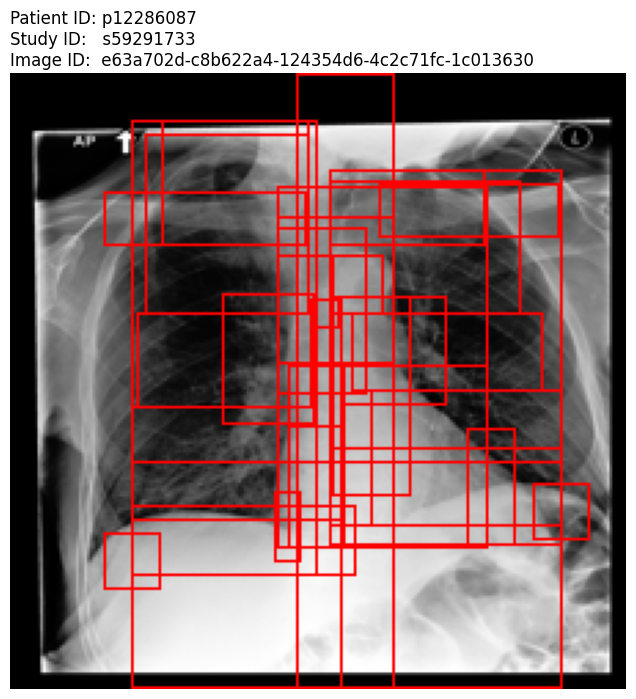

In [22]:
# pick a random image and find its corresponding image file name
rand_idx = np.random.randint(0, len(intersecting_images))
cur_img_id = intersecting_images[rand_idx]
req_idx = only_image_ids.index(cur_img_id)

# get patient id and study id
cur_patient_id = images[req_idx].split("/")[-3]
cur_study_id   = images[req_idx].split("/")[-2]

# read image and resize
img = Image.open(images[req_idx]).convert("RGB")
img = img.resize((224, 224))
img = np.array(img)

# find all bounding boxes for the current image
cur_img_boxes = df[df["image_id"] == cur_img_id][["x1", "y1", "x2", "y2"]].to_numpy()

# draw bounding boxes on the image
img_cpy = img.copy()
for x1, y1, x2, y2 in cur_img_boxes:
    cv.rectangle(img_cpy, (x1, y1), (x2, y2), (255, 0, 0), 1)

# plot the image
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f"Patient ID: {cur_patient_id}\nStudy ID:   {cur_study_id}\nImage ID:  {cur_img_id}", loc="left")
plt.imshow(img_cpy)

## Construct Graph

In [23]:
# get all bounding box names
bbox_names = sorted(list(set(df["bbox_name"].to_list())))
len(bbox_names)

36

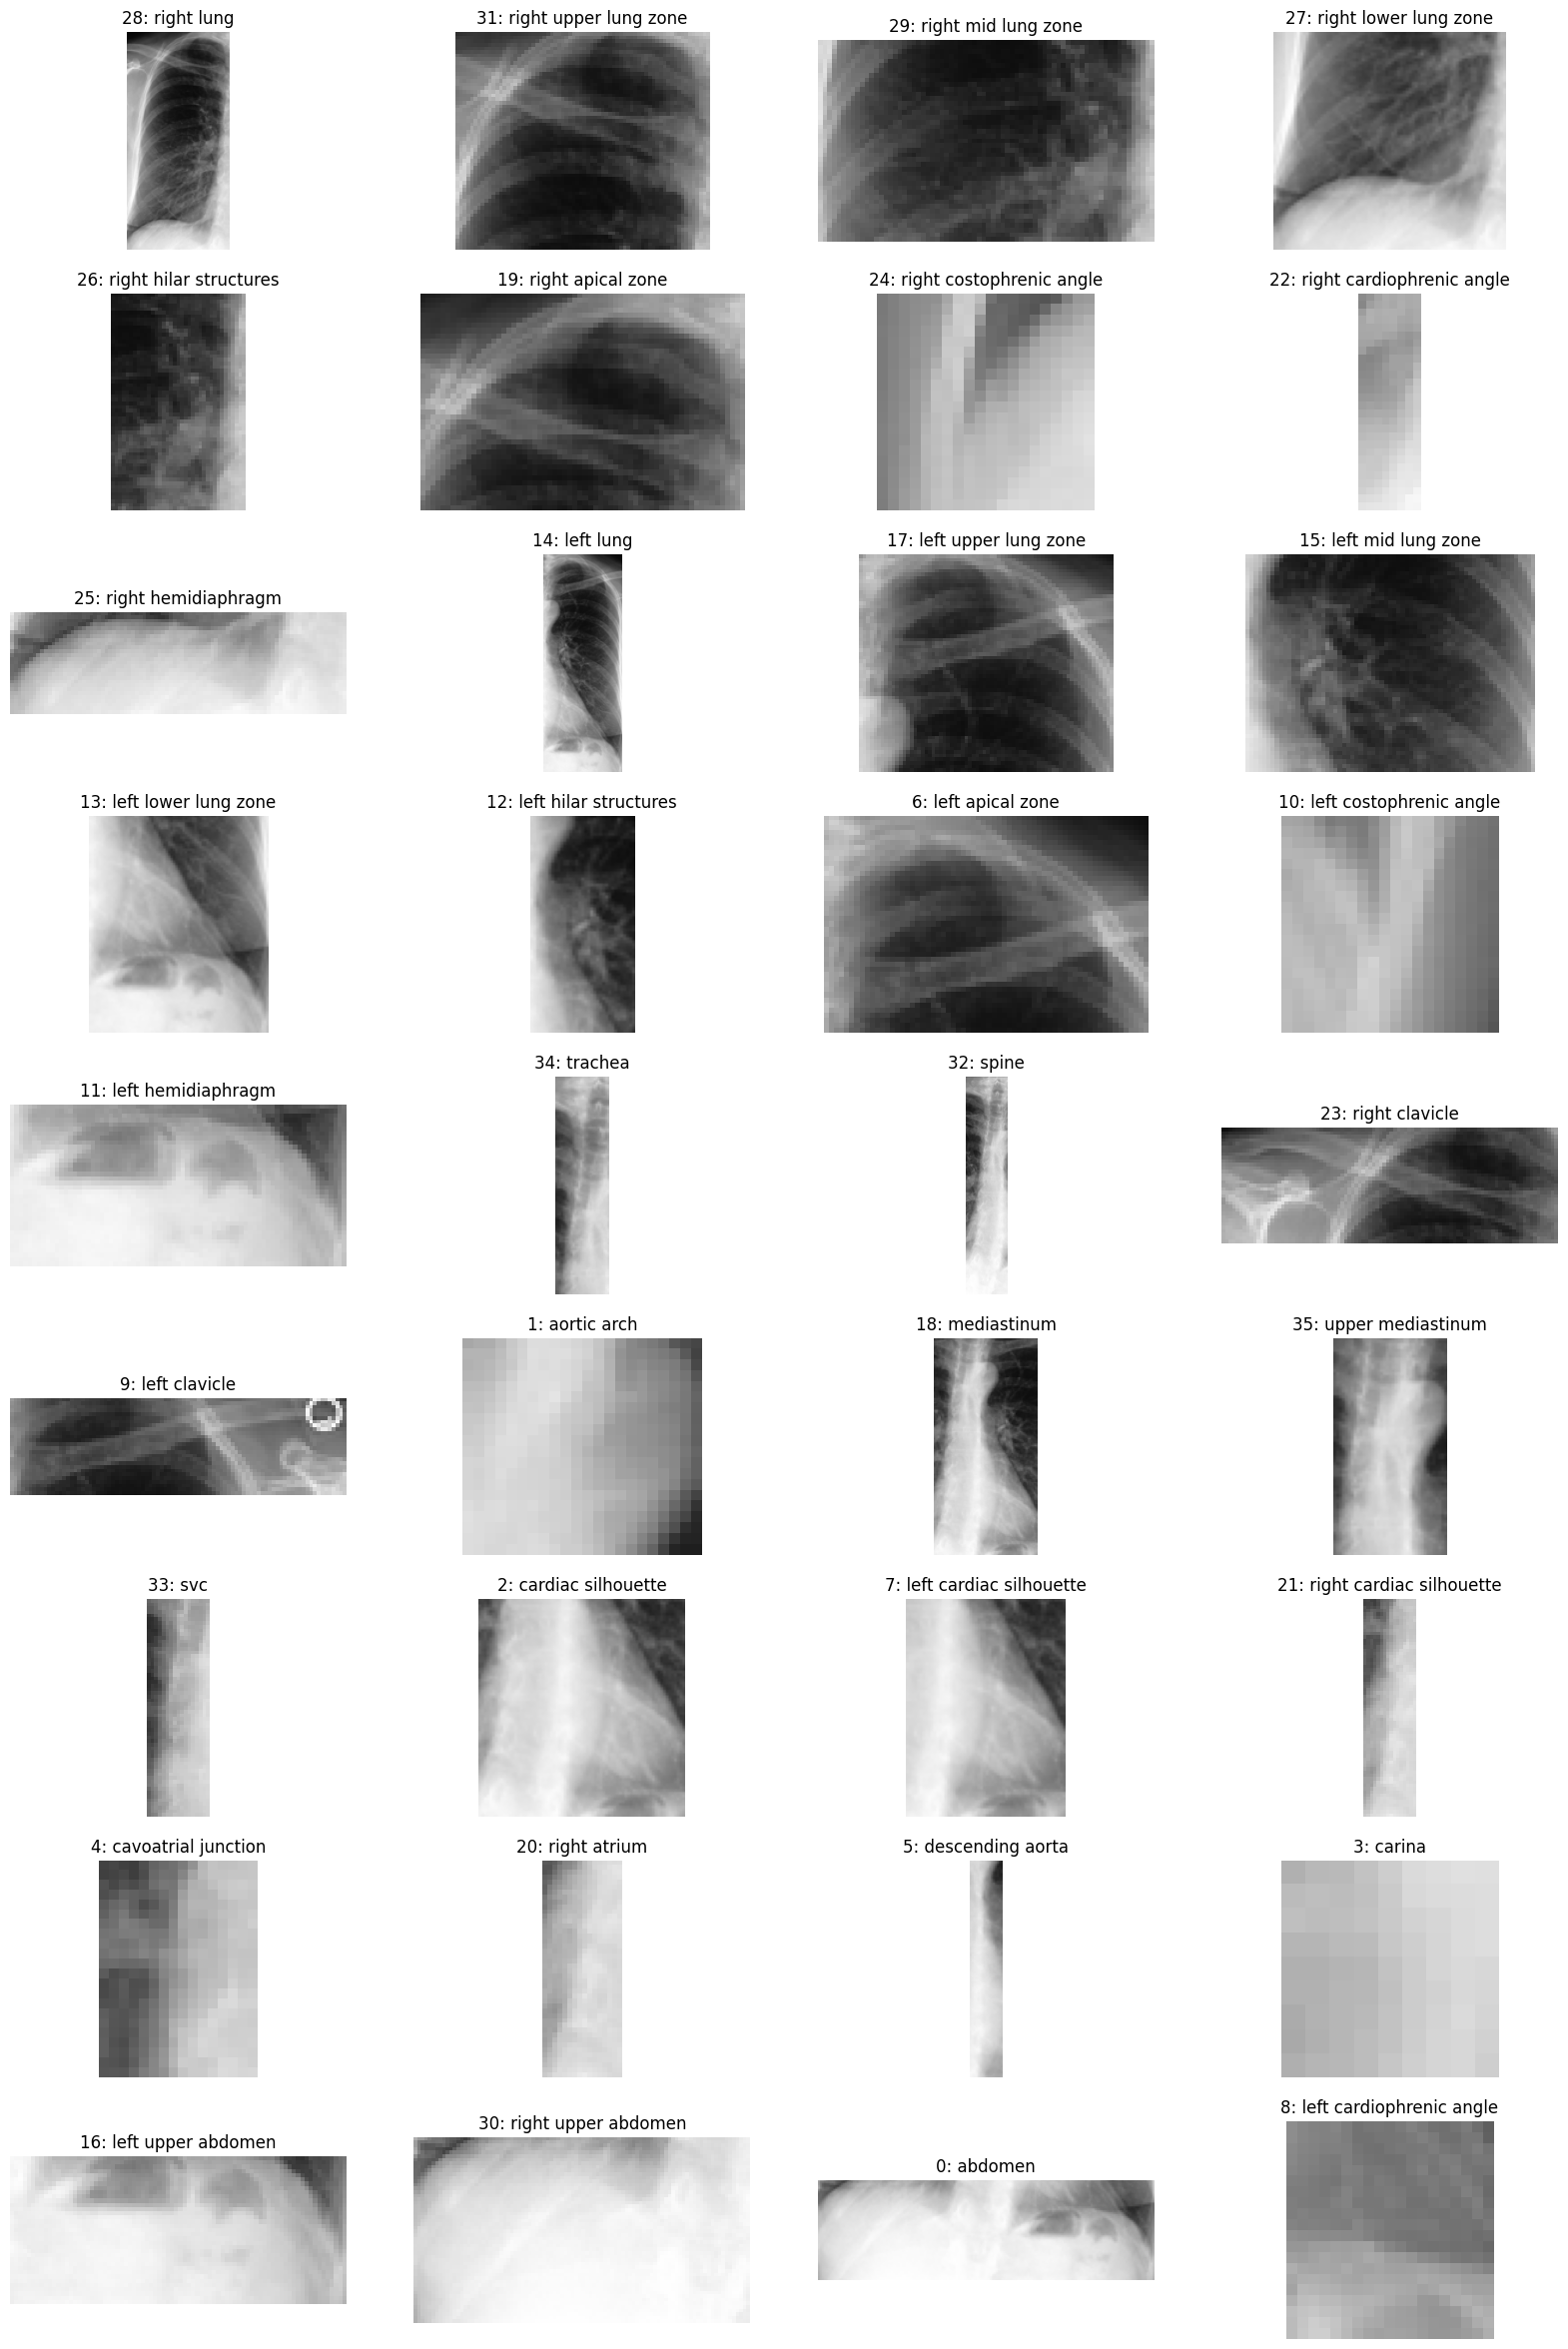

In [36]:
# pick a random image and find its corresponding image file name
rand_idx = np.random.randint(0, len(intersecting_images))
cur_img_id = intersecting_images[rand_idx]
req_idx = only_image_ids.index(cur_img_id)

# get patient id and study id
cur_patient_id = images[req_idx].split("/")[-3]
cur_study_id   = images[req_idx].split("/")[-2]

# read image and resize
img = Image.open(images[req_idx]).convert("RGB")
img = img.resize((224, 224))
img = np.array(img)

# extract graph info about the image
cur_img_boxes = df[df["image_id"] == cur_img_id][["x1", "y1", "x2", "y2", "bbox_name"]].to_numpy()

# get node features
node_idx = []
node_features = []
for i, (x1, y1, x2, y2, bbox_name) in enumerate(cur_img_boxes):
    node_idx.append(bbox_names.index(bbox_name))
    node_features.append(img[y1:y2, x1:x2, :])

# get adjacency matrix
adj_mat = []
for i, (x1, y1, x2, y2, bbox_name) in enumerate(cur_img_boxes):
    adj_mat.append([])
    for j, (x1_, y1_, x2_, y2_, bbox_name_) in enumerate(cur_img_boxes):
        # find intersection over union
        intersection = max(0, min(x2, x2_) - max(x1, x1_)) * max(0, min(y2, y2_) - max(y1, y1_))
        union = (x2 - x1) * (y2 - y1) + (x2_ - x1_) * (y2_ - y1_) - intersection
        iou = intersection / union
        adj_mat[i].append(iou)
adj_mat = np.array(adj_mat)

# threshold the adjacency matrix
threshold = 0.5
adj_mat = np.where(adj_mat > threshold, 1, 0)
    
# print each feature as a separate image in a grid
plt.figure(figsize=(20, 30))
for i, (idx, feature) in enumerate(zip(node_idx, node_features)):
    plt.subplot(len(node_idx)//4, 4, i+1)
    plt.axis('off')
    plt.title(f"{idx}: {bbox_names[idx]}")
    plt.imshow(feature)
plt.savefig("node_imgs.png")

In [25]:
from torchvision import transforms

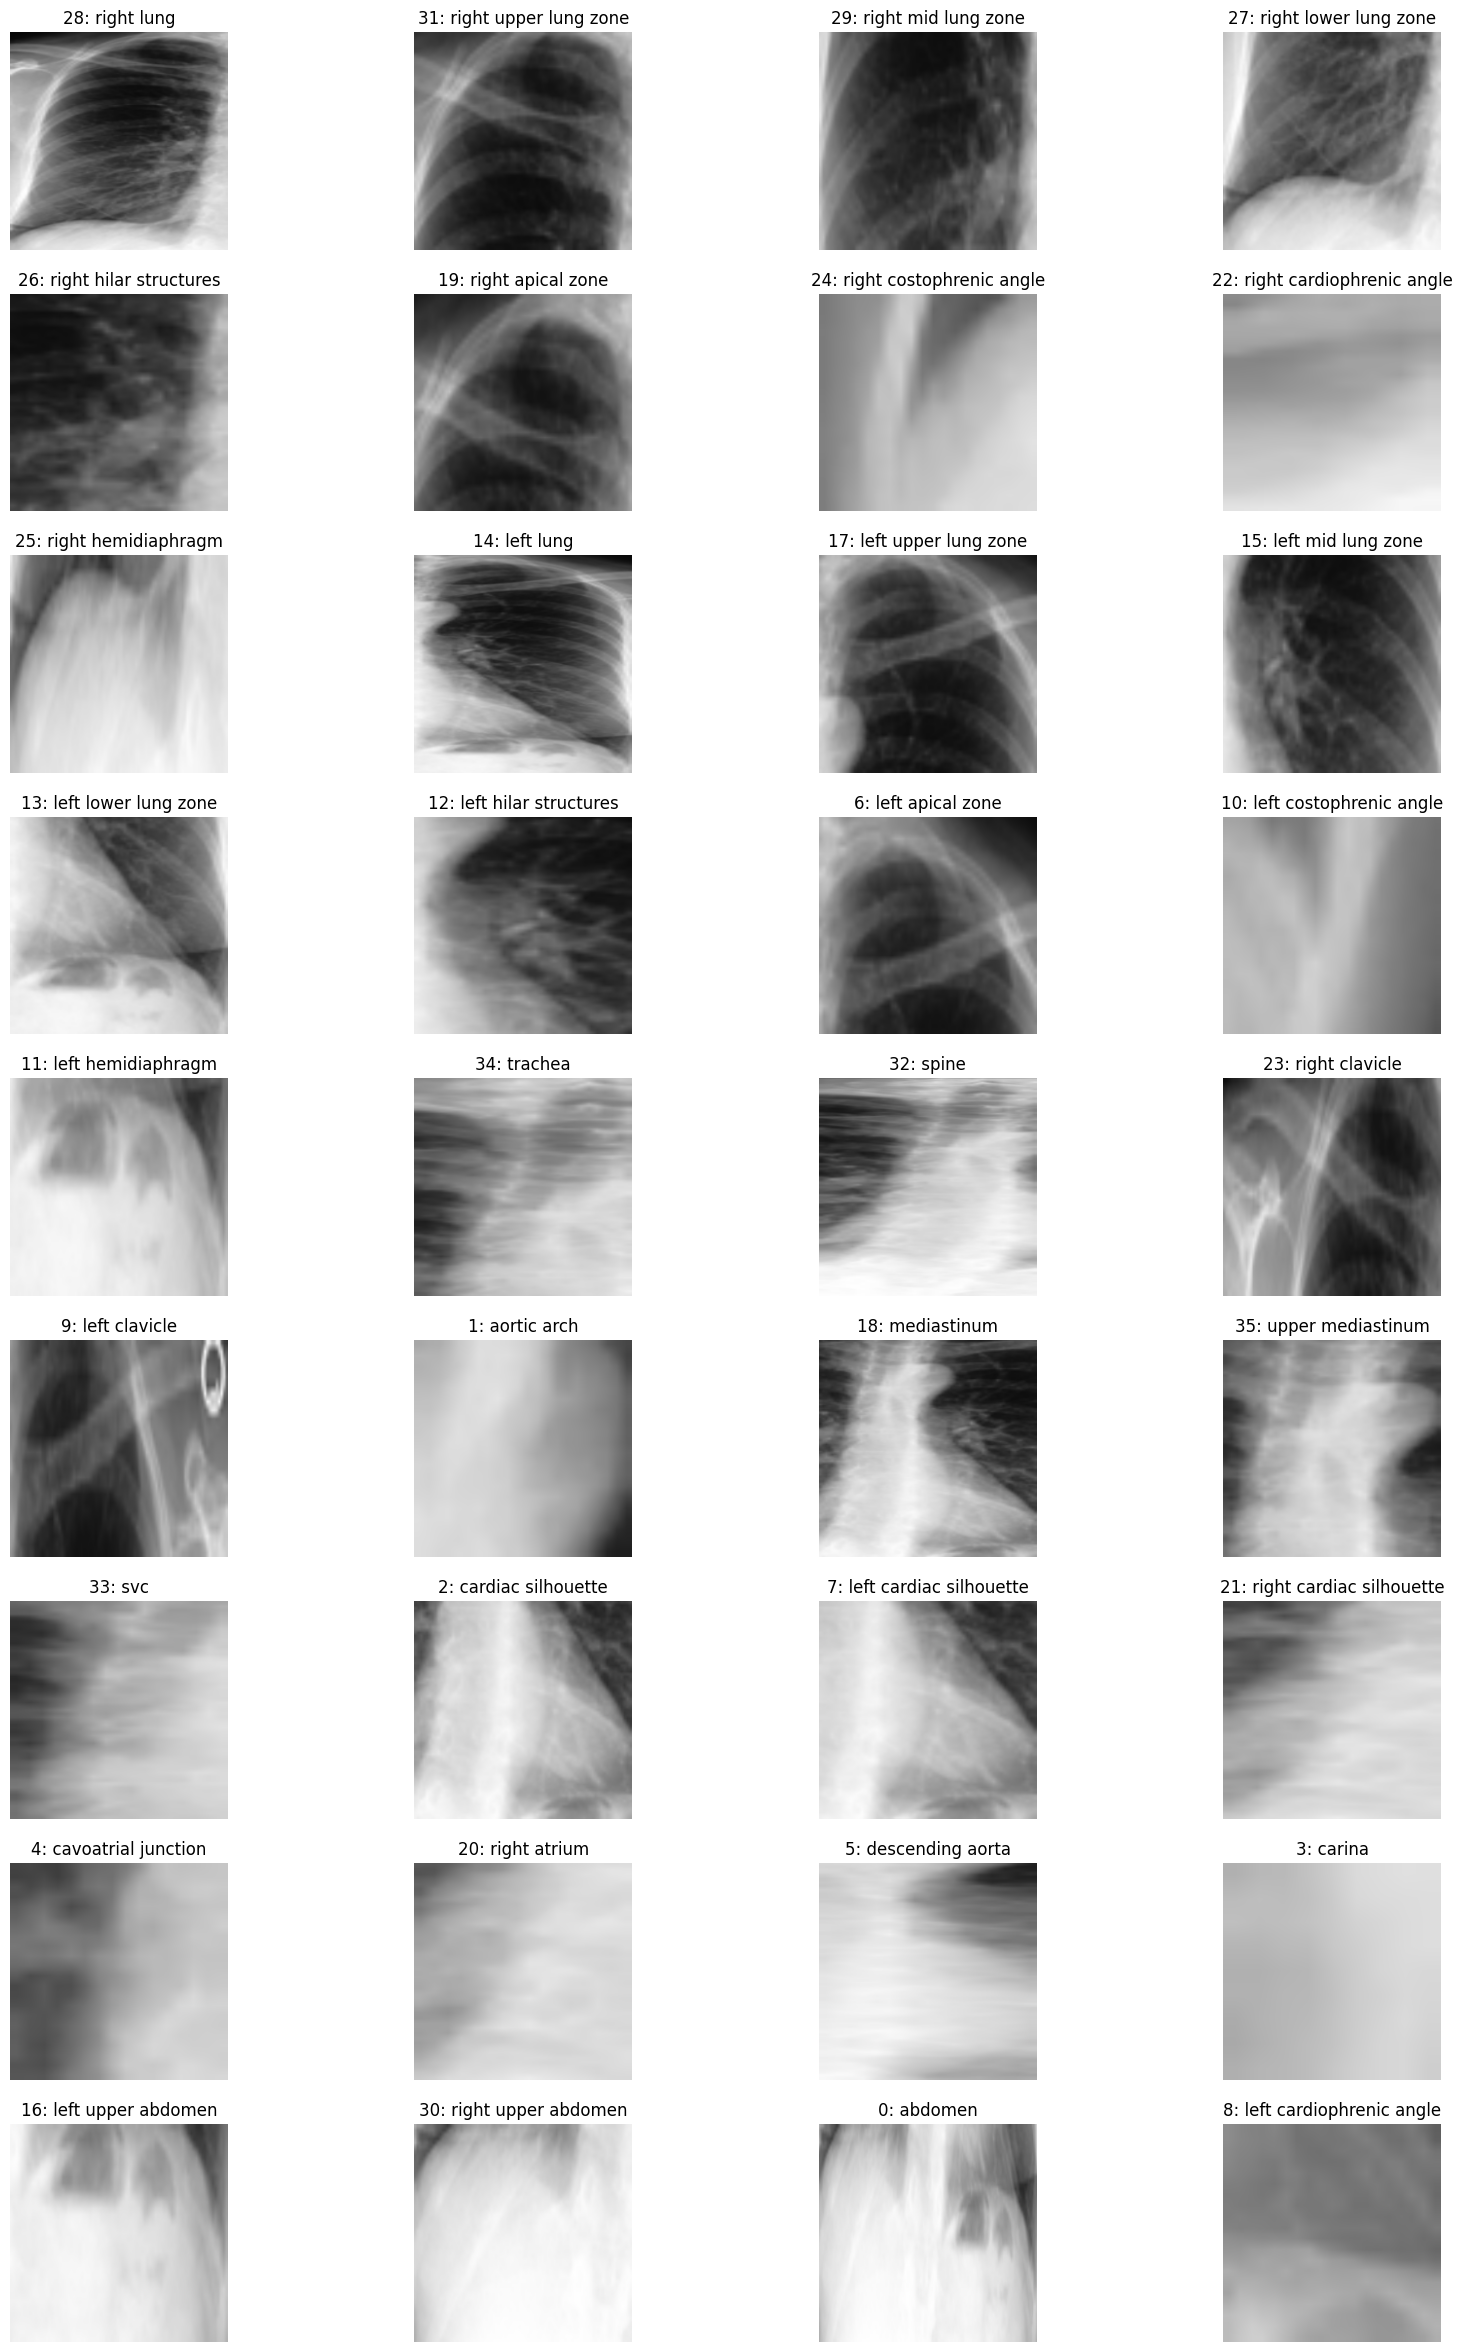

In [37]:
# pick a random image and find its corresponding image file name
cur_img_id = intersecting_images[rand_idx]
req_idx = only_image_ids.index(cur_img_id)

# get patient id and study id
cur_patient_id = images[req_idx].split("/")[-3]
cur_study_id   = images[req_idx].split("/")[-2]

# read image and resize
img = Image.open(images[req_idx]).convert("RGB")
img = img.resize((224, 224))
img = np.array(img)

# extract graph info about the image
cur_img_boxes = df[df["image_id"] == cur_img_id][["x1", "y1", "x2", "y2", "bbox_name"]].to_numpy()

# get node features
node_idx = []
node_features = []
for i, (x1, y1, x2, y2, bbox_name) in enumerate(cur_img_boxes):
    node_idx.append(bbox_names.index(bbox_name))
    tiny_img = torch.tensor(img[y1:y2, x1:x2, :]).permute(2, 0, 1)
    node_features.append(transforms.Resize((224, 224), antialias=True)(tiny_img).permute(1, 2, 0).numpy())

# get adjacency matrix
adj_mat = []
for i, (x1, y1, x2, y2, bbox_name) in enumerate(cur_img_boxes):
    adj_mat.append([])
    for j, (x1_, y1_, x2_, y2_, bbox_name_) in enumerate(cur_img_boxes):
        # find intersection over union
        intersection = max(0, min(x2, x2_) - max(x1, x1_)) * max(0, min(y2, y2_) - max(y1, y1_))
        union = (x2 - x1) * (y2 - y1) + (x2_ - x1_) * (y2_ - y1_) - intersection
        iou = intersection / union
        adj_mat[i].append(iou)
adj_mat = np.array(adj_mat)

# threshold the adjacency matrix
threshold = 0.5
adj_mat = np.where(adj_mat > threshold, 1, 0)
    
# print each feature as a separate image in a grid
plt.figure(figsize=(20, 30))
for i, (idx, feature) in enumerate(zip(node_idx, node_features)):
    plt.subplot(len(node_idx)//4, 4, i+1)
    plt.axis('off')
    plt.title(f"{idx}: {bbox_names[idx]}")
    plt.imshow(feature)
plt.savefig("node_imgs_resized.png")

## Transform to Graph

In [58]:
import torch
import numpy as np
from graph_transformer.graph_transformer_pytorch import GraphTransformer

In [60]:
num_node = 37
node_dim = 1024
edge_dim = 128

In [61]:
node_idx = np.arange(num_node)
np.random.shuffle(node_idx)
node_idx.shape

(37,)

In [62]:
node_feats = np.random.rand(num_node, node_dim)
node_feats.shape

(37, 1024)

In [63]:
edges = np.random.rand(num_node, num_node, edge_dim)
adj_mat = np.where(edges.sum(axis=2) > 0.5*edge_dim, 1, 0)
edges.shape, adj_mat.shape

((37, 37, 128), (37, 37))

In [64]:
mask = np.ones(num_node, dtype=np.bool_)
mask.shape

(37,)

In [65]:
node_idx = torch.tensor(node_idx).long().unsqueeze(0)
node_feats = torch.tensor(node_feats).float().unsqueeze(0)
edges = torch.tensor(edges).float().unsqueeze(0)
adj_mat = torch.tensor(adj_mat).float().unsqueeze(0)
mask = torch.tensor(mask).bool().unsqueeze(0)

node_idx.shape, node_feats.shape, edges.shape, adj_mat.shape, mask.shape

(torch.Size([1, 37]),
 torch.Size([1, 37, 1024]),
 torch.Size([1, 37, 37, 128]),
 torch.Size([1, 37, 37]),
 torch.Size([1, 37]))

In [72]:
model = GraphTransformer(
    dim = node_dim,
    depth = 2,
    # edge_dim = edge_dim,
    with_feedforwards = True,
    gated_residual = True,
    abs_pos_emb = True,
    accept_adjacency_matrix = True,
)

In [73]:
# nodes, edges = model(node_feats, edges, adj_mat=adj_mat, mask=mask, positions=node_idx)
nodes, edges = model(node_feats, adj_mat=adj_mat, mask=mask, positions=node_idx)

In [74]:
# nodes.shape, edges.shape
nodes.shape

torch.Size([1, 37, 1024])

# Dataloader

In [51]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [127]:
class CustomDataset(Dataset):
    
    def __init__(self,
                 data_prefix: str="/ssd_scratch/cvit/arihanth/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/scene_tabular/",
                 images_dir: str="/ssd_scratch/cvit/arihanth/physionet.org/files/mimic-cxr-jpg/2.0.0/files/",
                 split: str="val",
                 to_gen: int=-1) -> None:
        
        split = 'validate' if 'val' in split else split
        
        # bounding box files are stored here
        # data_prefix = "/ssd_scratch/cvit/arihanth/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/scene_tabular/"

        # chest x-ray images are stored here
        # images_dir = "/ssd_scratch/cvit/arihanth/physionet.org/files/mimic-cxr-jpg/2.0.0/files/"
        
        self.images = sorted(glob(images_dir + "/**/*.npy", recursive=True))
        self.is_numpy = len(self.images) > 0
        self.images = sorted(glob(images_dir + "/**/*.jpg", recursive=True)) if not self.is_numpy else self.images

        df = pd.read_pickle(f"{data_prefix}processed_bboxes.pkl")
        df1 = pd.read_csv('data/mimic_cxr_jpg/mimic-cxr-2.0.0-chexpert.csv').fillna(0).replace(-1, 0)
        df2 = pd.read_csv('data/mimic_cxr_jpg/mimic-cxr-2.0.0-split.csv')
        df_split = pd.merge(df1, df2, on=['subject_id', 'study_id'])
        df_split.rename({'dicom_id': 'image_id'}, axis=1, inplace=True)
        df = pd.merge(df_split, df, on=['image_id'])
        self.df = df[df["split"] == split] if split != 'all' else df

        # find all images that have bounding boxes
        self.intersecting_images = list(set(self.df["image_id"].to_list()) & set([fn.split("/")[-1].split(".")[0] for fn in self.images]))

        # store only image id and maintain same indexing
        self.only_image_ids = [fn.split("/")[-1].split(".")[0] for fn in self.images]

        # get all bounding box names
        self.bbox_names = sorted(list(set(self.df["bbox_name"].to_list())))

        # decide length of dataset
        self.to_gen = len(self.intersecting_images) if to_gen == -1 else to_gen

        # define transform
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
            # transforms.Normalize((0.5,), (0.5,))
        ])
        
    def __len__(self):
        return self.to_gen
    
    def __getitem__(self, idx):
        # pick a random image (if req) and find its corresponding image file name
        rand_idx = torch.randint(0, len(self.intersecting_images), (1,)).item() if self.to_gen != len(self.intersecting_images) else idx
        cur_img_id = self.intersecting_images[rand_idx]
        req_idx = self.only_image_ids.index(cur_img_id)

        # get patient id and study id
        cur_patient_id = self.images[req_idx].split("/")[-3]
        cur_study_id   = self.images[req_idx].split("/")[-2]

        if self.is_numpy:
            # read image and convert to RGB
            img = np.load(self.images[req_idx])
            img = torch.tensor(img, dtype=torch.float32).repeat(3, 1, 1)
        else:
            # read image and resize
            img = Image.open(self.images[req_idx])
            img = self.transform(img)

        # extract graph info about the image
        cur_img_boxes = self.df[self.df["image_id"] == cur_img_id][["x1", "y1", "x2", "y2", "bbox_name"]].to_numpy()
        labels = self.df[self.df["image_id"] == cur_img_id].values.tolist()[0][2:14]

        # get node features
        node_idx = []
        node_features = []
        for i, (x1, y1, x2, y2, bbox_name) in enumerate(cur_img_boxes):
            node_idx.append(self.bbox_names.index(bbox_name))
            node_features.append(img[:, y1:y2, x1:x2])

        # get adjacency matrix
        edges = []
        for i, (x1, y1, x2, y2, _) in enumerate(cur_img_boxes):
            edges.append([])
            for j, (x1_, y1_, x2_, y2_, _) in enumerate(cur_img_boxes):
                # find intersection over union
                intersection = max(0, min(x2, x2_) - max(x1, x1_)) * max(0, min(y2, y2_) - max(y1, y1_))
                union = (x2 - x1) * (y2 - y1) + (x2_ - x1_) * (y2_ - y1_) - intersection
                iou = intersection / union
                edges[i].append(iou)
        edges = np.array(edges)

        # threshold the adjacency matrix
        threshold = 0.2
        adj_mat = np.where(edges > threshold, 1, 0)

        # get node stuff
        node_idx = torch.tensor(node_idx).long()
        
        # have to pad node features as they are of different sized images
        largest_right  = max([node_features[i].shape[2] for i in range(len(node_features))])
        largest_bottom = max([node_features[i].shape[1] for i in range(len(node_features))])

        node_features = [torch.nn.functional.pad(node_features[i], (0, largest_right - node_features[i].shape[2], 0, largest_bottom - node_features[i].shape[1], 0, 0)) for i in range(len(node_features))]
        node_features = torch.stack(node_features)
        
        # get adjacency matrix and edge features
        adj_mat = torch.tensor(adj_mat).float()
        edges = torch.tensor(edges).float()

        gamma = 2
        edges_copy = torch.arange(-1, 1, 2/128).repeat(edges.shape[0], edges.shape[1], 1)
        edges = torch.exp(-gamma*(torch.pow(edges_copy-edges.unsqueeze(-1), 2)))

        # get mask and labels
        mask = torch.ones(len(node_idx)).bool()
        labels = torch.tensor(labels).float()

        return img, node_idx, node_features, edges, adj_mat, mask, labels
    
    def collate_fn(self, batch):
        img, node_idx, node_features, edges, adj_mat, mask, labels = zip(*batch)
        
        # can stack them as they are of same size
        img = torch.stack(img)
        node_idx = torch.stack(node_idx)
        edges = torch.stack(edges)
        adj_mat = torch.stack(adj_mat)
        mask = torch.stack(mask)
        labels = torch.stack(labels)

        # have to pad node features as they are of different sized images
        largest_right  = max([node_features[i].shape[3] for i in range(len(node_features))])
        largest_bottom = max([node_features[i].shape[2] for i in range(len(node_features))])

        node_features = [torch.nn.functional.pad(node_features[i], (0, largest_right - node_features[i].shape[3], 0, largest_bottom - node_features[i].shape[2], 0, 0)) for i in range(len(node_features))]
        node_features = torch.stack(node_features)

        return img, node_idx, node_features, edges, adj_mat, mask, labels
    

In [128]:
graph_dataset = CustomDataset(
    data_prefix="/ssd_scratch/cvit/arihanth/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/scene_tabular/", 
    images_dir="/ssd_scratch/cvit/arihanth/physionet.org/files/mimic-cxr-jpg/2.0.0/files/", 
    split="val",
    to_gen=-1)

In [150]:
graph_loader = DataLoader(graph_dataset, batch_size=2, collate_fn=graph_dataset.collate_fn)

In [151]:
img, node_idx, node_features, edge_feats, adj_mat, mask, labels = next(iter(graph_loader))

In [152]:
img.shape, node_idx.shape, node_features.shape, edge_feats.shape, adj_mat.shape, mask.shape, labels.shape

(torch.Size([2, 3, 224, 224]),
 torch.Size([2, 36]),
 torch.Size([2, 36, 3, 223, 192]),
 torch.Size([2, 36, 36, 20]),
 torch.Size([2, 36, 36]),
 torch.Size([2, 36]),
 torch.Size([2, 12]))

In [153]:
import os
from torchvision.models import densenet121, DenseNet121_Weights

os.environ['TORCH_HOME'] = '/ssd_scratch/cvit'

In [154]:
model = densenet121(weights=DenseNet121_Weights.DEFAULT)
model.classifier = torch.nn.Identity()

In [155]:
b, n, c, h, w = node_features.shape

In [156]:
node_feats = model(node_features.reshape(-1, c, h, w))
node_feats.shape

torch.Size([72, 1024])

In [157]:
node_feats = node_feats.reshape(b, n, -1)
node_feats.shape

torch.Size([2, 36, 1024])

In [158]:
graph_model = GraphTransformer(
    dim = 1024,
    depth = 2,
    edge_dim = 20,
    with_feedforwards = True,
    gated_residual = True,
    abs_pos_emb = True,
    accept_adjacency_matrix = True,
)

In [159]:
nodes, edges = graph_model(node_feats, edge_feats, adj_mat=adj_mat, mask=mask, positions=node_idx)

In [160]:
nodes.shape, edge_feats.shape

(torch.Size([2, 36, 1024]), torch.Size([2, 36, 36, 20]))

In [161]:
graph_emb = torch.mean(nodes, dim=1) + model(img)
graph_emb.shape

torch.Size([2, 1024])

: 